# Section 1: Business Understanding

As described in the README file, we have used the latest Airbnb public dataset to perform a
data analysis on different cities from The Netherlands. It contains listing information from
06.2021 until 06.2022. We want to see what would be the best
places to rent a property on Airbnb.

Our goal is to respond to the questions from below.

##### Question 1: Which city has the highest price tag? What about their neighborhoods?
##### Question 2: What city and neighborhoods are in most demand?
##### Question 3: Are reviews for more expensive houses better?
##### Question 4: What are the factors that affect a property's price?

In [1]:
import os
import glob

from collections import Counter
from pathlib import Path
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt


from matplotlib.ticker import FormatStrFormatter, MultipleLocator
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Section 2: Data Understanding
First we will take a look only at the Amsterdam city to understand the data structure.

In [2]:
def read_city(city_data_dir: str):
    """
    Reads the data from a single city.

        :param city_data_dir: String path to the directory that contains the listing.csv file.

        :return: DataFrame that contains the data.
    """

    city_data_dir = Path(city_data_dir)

    listings_df = pd.read_csv(city_data_dir / "listings.csv")
    df = listings_df.set_index(keys=["id"])

    return df

In [3]:
amsterdam_df = read_city(city_data_dir="./data/Amsterdam")

In [4]:
amsterdam_df.head()

,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
2818,https://www.airbnb.com/rooms/2818,20220308023209,2022-03-08,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi<br />...,"Indische Buurt (""Indies Neighborhood"") is a ne...",https://a0.muscache.com/pictures/10272854/8dcc...,3159,https://www.airbnb.com/users/show/3159,Daniel,...,4.98,4.68,4.82,0363 5F3A 5684 6750 D14D,t,1,0,1,0,1.81
20168,https://www.airbnb.com/rooms/20168,20220308023209,2022-03-31,Studio with private bathroom in the centre 1,17th century Dutch townhouse in the heart of t...,Located just in between famous central canals....,https://a0.muscache.com/pictures/69979628/fd6a...,59484,https://www.airbnb.com/users/show/59484,Alexander,...,4.62,4.87,4.49,0363 CBB3 2C10 0C2A 1E29,t,2,0,2,0,2.30
27886,https://www.airbnb.com/rooms/27886,20220308023209,2022-03-08,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,"Central, quiet, safe, clean and beautiful.",https://a0.muscache.com/pictures/02c2da9d-660e...,97647,https://www.airbnb.com/users/show/97647,Flip,...,4.92,4.89,4.79,0363 974D 4986 7411 88D8,t,1,0,1,0,1.84
28871,https://www.airbnb.com/rooms/28871,20220308023209,2022-03-08,Comfortable double room,<b>The space</b><br />In a monumental house ri...,"Flower market , Leidseplein , Rembrantsplein",https://a0.muscache.com/pictures/160889/362340...,124245,https://www.airbnb.com/users/show/124245,Edwin,...,4.94,4.97,4.82,0363 607B EA74 0BD8 2F6F,f,2,0,2,0,2.70
29051,https://www.airbnb.com/rooms/29051,20220308023209,2022-03-08,Comfortable single room,This room can also accomodate 2 people. For a...,the street is quite lively especially on weeke...,https://a0.muscache.com/pictures/162009/bd6be2...,124245,https://www.airbnb.com/users/show/124245,Edwin,...,4.91,4.87,4.75,0363 607B EA74 0BD8 2F6F,f,2,0,2,0,3.98


In [5]:
amsterdam_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5732 entries, 2818 to 575735254328900114
Data columns (total 73 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_url                                   5732 non-null   object 
 1   scrape_id                                     5732 non-null   int64  
 2   last_scraped                                  5732 non-null   object 
 3   name                                          5732 non-null   object 
 4   description                                   5716 non-null   object 
 5   neighborhood_overview                         4054 non-null   object 
 6   picture_url                                   5732 non-null   object 
 7   host_id                                       5732 non-null   int64  
 8   host_url                                      5732 non-null   object 
 9   host_name                                     

In [6]:
amsterdam_df.describe()

,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,5.732000e+03,5.732000e+03,5732.000000,5732.000000,0.0,5732.000000,5732.000000,5732.000000,0.0,5405.000000,...,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5732.000000,5732.000000,5732.000000,5732.000000,5156.000000
mean,2.022031e+13,9.178522e+07,2.958653,2.958653,NaN,52.366941,4.891896,2.954641,NaN,1.571138,...,4.750567,4.873002,4.880128,4.776318,4.643021,2.205862,1.085311,0.983426,0.024773,1.107719
std,0.000000e+00,1.187621e+08,32.962427,32.962427,NaN,0.017964,0.038285,1.489931,NaN,0.920397,...,0.323958,0.237898,0.247172,0.243932,0.304714,3.127854,1.700549,2.468840,0.248704,2.085598
min,2.022031e+13,3.159000e+03,0.000000,0.000000,NaN,52.277520,4.753340,0.000000,NaN,1.000000,...,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.022031e+13,9.164086e+06,1.000000,1.000000,NaN,52.356277,4.868655,2.000000,NaN,1.000000,...,4.660000,4.840000,4.860000,4.670000,4.530000,1.000000,0.000000,0.000000,0.000000,0.250000
50%,2.022031e+13,3.171299e+07,1.000000,1.000000,NaN,52.366470,4.888655,2.000000,NaN,1.000000,...,4.850000,4.940000,4.960000,4.830000,4.690000,1.000000,1.000000,0.000000,0.000000,0.510000
75%,2.022031e+13,1.377074e+08,2.000000,2.000000,NaN,52.376740,4.909320,4.000000,NaN,2.000000,...,4.970000,5.000000,5.000000,4.970000,4.810000,2.000000,1.000000,1.000000,0.000000,1.192500
max,2.022031e+13,4.478697e+08,2239.000000,2239.000000,NaN,52.430760,5.070100,16.000000,NaN,15.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,20.000000,15.000000,20.000000,4.000000,78.940000


In [7]:
amsterdam_df.dtypes

listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
description                                      object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 73, dtype: object

In [8]:
amsterdam_df.isna().sum()

listing_url                                       0
scrape_id                                         0
last_scraped                                      0
name                                              0
description                                      16
                                               ... 
calculated_host_listings_count                    0
calculated_host_listings_count_entire_homes       0
calculated_host_listings_count_private_rooms      0
calculated_host_listings_count_shared_rooms       0
reviews_per_month                               576
Length: 73, dtype: int64

#### Now Read All the Cities

In [9]:
def read_all(data_dir: str) -> pd.DataFrame:
    """
    Read and aggregate the data from all the cities.

        :param data_dir: Path to the root directory that contains the city directories (e.g. Amsterdam, Rotterdam, etc.)

        :return: A DataFrame that contains all the data.
    """
    aggregated_df = None
    for city_dir in glob.glob(os.path.join(data_dir, "*")):
        if os.path.isdir(city_dir) and "features" not in city_dir:
            city = os.path.split(city_dir)[-1]
            df = read_city(city_dir)
            df["city"] = city

            if aggregated_df is None:
                aggregated_df = df
            else:
                assert len(set(aggregated_df.index).intersection(set(df.index))) == 0, "Listings overlapped."

                aggregated_df = pd.concat([aggregated_df, df], axis=0)

    return aggregated_df

In [10]:
df = read_all("./data/")

In [11]:
df.head()

,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city
id,,,,,,,,,,,,,,,,,,,,,
2818,https://www.airbnb.com/rooms/2818,20220308023209,2022-03-08,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi<br />...,"Indische Buurt (""Indies Neighborhood"") is a ne...",https://a0.muscache.com/pictures/10272854/8dcc...,3159,https://www.airbnb.com/users/show/3159,Daniel,...,4.68,4.82,0363 5F3A 5684 6750 D14D,t,1,0,1,0,1.81,Amsterdam
20168,https://www.airbnb.com/rooms/20168,20220308023209,2022-03-31,Studio with private bathroom in the centre 1,17th century Dutch townhouse in the heart of t...,Located just in between famous central canals....,https://a0.muscache.com/pictures/69979628/fd6a...,59484,https://www.airbnb.com/users/show/59484,Alexander,...,4.87,4.49,0363 CBB3 2C10 0C2A 1E29,t,2,0,2,0,2.30,Amsterdam
27886,https://www.airbnb.com/rooms/27886,20220308023209,2022-03-08,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,"Central, quiet, safe, clean and beautiful.",https://a0.muscache.com/pictures/02c2da9d-660e...,97647,https://www.airbnb.com/users/show/97647,Flip,...,4.89,4.79,0363 974D 4986 7411 88D8,t,1,0,1,0,1.84,Amsterdam
28871,https://www.airbnb.com/rooms/28871,20220308023209,2022-03-08,Comfortable double room,<b>The space</b><br />In a monumental house ri...,"Flower market , Leidseplein , Rembrantsplein",https://a0.muscache.com/pictures/160889/362340...,124245,https://www.airbnb.com/users/show/124245,Edwin,...,4.97,4.82,0363 607B EA74 0BD8 2F6F,f,2,0,2,0,2.70,Amsterdam
29051,https://www.airbnb.com/rooms/29051,20220308023209,2022-03-08,Comfortable single room,This room can also accomodate 2 people. For a...,the street is quite lively especially on weeke...,https://a0.muscache.com/pictures/162009/bd6be2...,124245,https://www.airbnb.com/users/show/124245,Edwin,...,4.87,4.75,0363 607B EA74 0BD8 2F6F,f,2,0,2,0,3.98,Amsterdam


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7164 entries, 2818 to 588089624475242042
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_url                                   7164 non-null   object 
 1   scrape_id                                     7164 non-null   int64  
 2   last_scraped                                  7164 non-null   object 
 3   name                                          7164 non-null   object 
 4   description                                   7140 non-null   object 
 5   neighborhood_overview                         4973 non-null   object 
 6   picture_url                                   7164 non-null   object 
 7   host_id                                       7164 non-null   int64  
 8   host_url                                      7164 non-null   object 
 9   host_name                                     

In [13]:
df.describe()

,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,7.164000e+03,7.164000e+03,7164.000000,7164.000000,7164.000000,7164.000000,7164.000000,0.0,6721.000000,7033.000000,...,6359.000000,6359.000000,6359.000000,6359.000000,6359.000000,7164.000000,7164.000000,7164.000000,7164.000000,6371.000000
mean,2.022031e+13,9.653166e+07,3.577610,3.577610,52.294812,4.789088,3.012702,NaN,1.589347,2.028722,...,4.739623,4.870061,4.873406,4.779607,4.641357,2.835567,1.530988,1.144333,0.025824,1.132675
std,6.053955e+06,1.228790e+08,30.421989,30.421989,0.149936,0.212991,1.602379,NaN,0.992277,1.854345,...,0.343973,0.248962,0.266773,0.263293,0.326392,5.192783,3.985036,3.035385,0.268974,1.974705
min,2.022031e+13,3.159000e+03,0.000000,0.000000,51.856810,4.079280,0.000000,NaN,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.022031e+13,9.285412e+06,1.000000,1.000000,52.342818,4.846490,2.000000,NaN,1.000000,1.000000,...,4.640000,4.840000,4.860000,4.670000,4.530000,1.000000,0.000000,0.000000,0.000000,0.250000
50%,2.022031e+13,3.433970e+07,1.000000,1.000000,52.361925,4.879840,2.000000,NaN,1.000000,1.000000,...,4.840000,4.940000,4.960000,4.850000,4.700000,1.000000,1.000000,0.000000,0.000000,0.530000
75%,2.022031e+13,1.454626e+08,2.000000,2.000000,52.374043,4.903960,4.000000,NaN,2.000000,2.000000,...,4.970000,5.000000,5.000000,4.980000,4.820000,2.000000,1.000000,1.000000,0.000000,1.340000
max,2.022032e+13,4.504283e+08,2239.000000,2239.000000,52.430760,5.070100,16.000000,NaN,23.000000,46.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,47.000000,42.000000,27.000000,5.000000,78.940000


In [14]:
df.dtypes

listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
description                                      object
                                                 ...   
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
city                                             object
Length: 74, dtype: object

In [15]:
df.isna().sum()

listing_url                                       0
scrape_id                                         0
last_scraped                                      0
name                                              0
description                                      24
                                               ... 
calculated_host_listings_count_entire_homes       0
calculated_host_listings_count_private_rooms      0
calculated_host_listings_count_shared_rooms       0
reviews_per_month                               793
city                                              0
Length: 74, dtype: int64

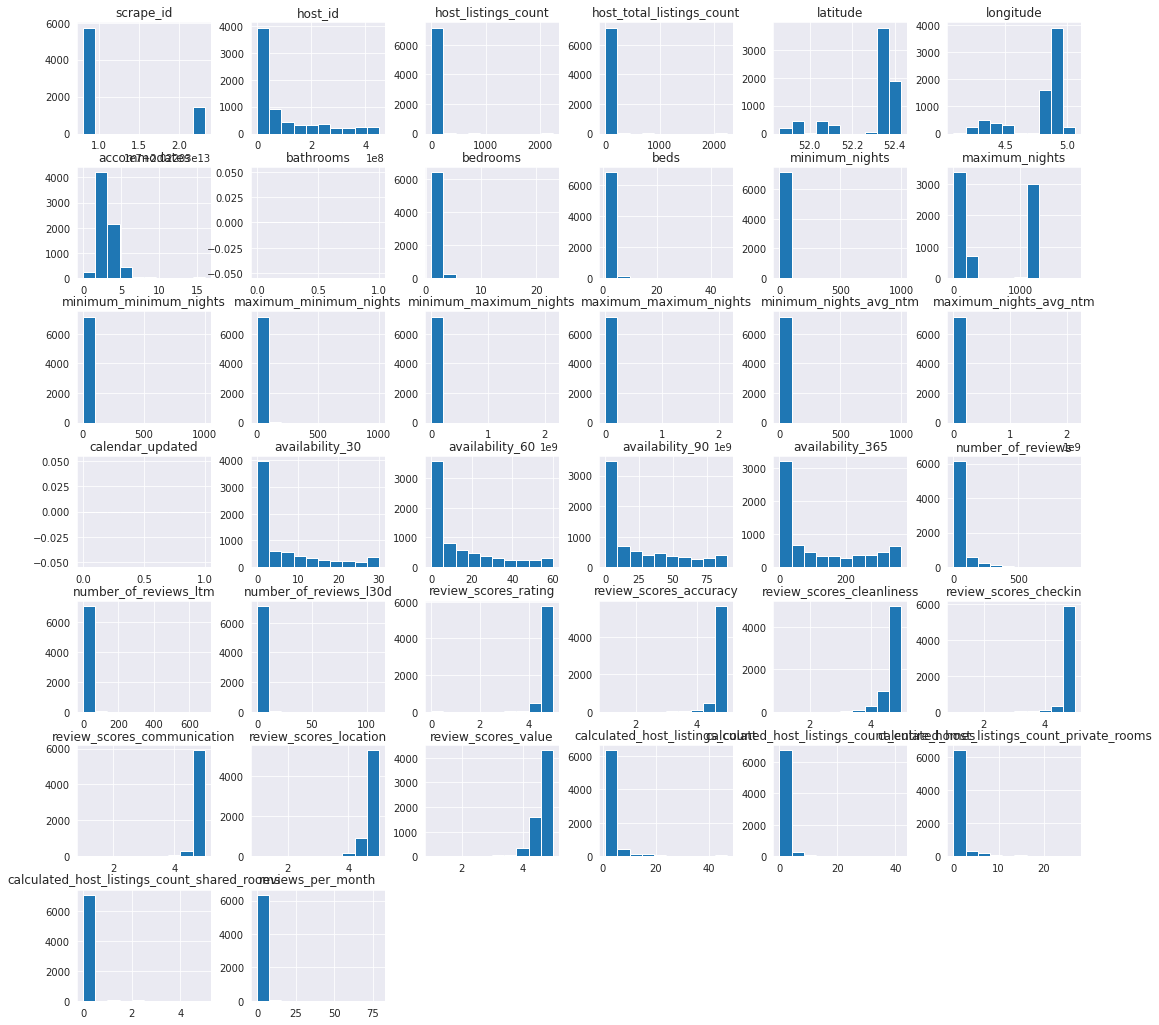

In [16]:
df.hist(figsize=(18, 18));

# Section 3: Data Preparation

## Drop Columns

### Let's See Which Columns Are Mainly NANs

In [17]:
def drop_columns_with_nans(df: pd.DataFrame, percentage: float) -> Tuple[pd.DataFrame, List[str]]:
    f"""
    Drops columns that have a NANs percentage bigger than {percentage}

        :param df: The DataFrame that we are looking in.
        :param percentage: Percentage threshold used to drop columns with a NAN ratio bigger than it.

        :return: The cleaned DataFrame.
    """

    assert 0 <= percentage <= 1

    nan_percentages = df.isna().mean()
    filtered_nan_percentages = nan_percentages[nan_percentages > percentage]
    to_drop_columns = list(filtered_nan_percentages.index)

    df = df.drop(columns=to_drop_columns).copy()

    return df, to_drop_columns

In [18]:
cleaned_df, dropped_columns = drop_columns_with_nans(df, percentage=0.8)

In [19]:
print(f"We have dropped the following columns: {dropped_columns}")

We have dropped the following columns: ['neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated']


In [20]:
cleaned_df.head()

,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city
id,,,,,,,,,,,,,,,,,,,,,
2818,https://www.airbnb.com/rooms/2818,20220308023209,2022-03-08,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi<br />...,"Indische Buurt (""Indies Neighborhood"") is a ne...",https://a0.muscache.com/pictures/10272854/8dcc...,3159,https://www.airbnb.com/users/show/3159,Daniel,...,4.68,4.82,0363 5F3A 5684 6750 D14D,t,1,0,1,0,1.81,Amsterdam
20168,https://www.airbnb.com/rooms/20168,20220308023209,2022-03-31,Studio with private bathroom in the centre 1,17th century Dutch townhouse in the heart of t...,Located just in between famous central canals....,https://a0.muscache.com/pictures/69979628/fd6a...,59484,https://www.airbnb.com/users/show/59484,Alexander,...,4.87,4.49,0363 CBB3 2C10 0C2A 1E29,t,2,0,2,0,2.30,Amsterdam
27886,https://www.airbnb.com/rooms/27886,20220308023209,2022-03-08,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,"Central, quiet, safe, clean and beautiful.",https://a0.muscache.com/pictures/02c2da9d-660e...,97647,https://www.airbnb.com/users/show/97647,Flip,...,4.89,4.79,0363 974D 4986 7411 88D8,t,1,0,1,0,1.84,Amsterdam
28871,https://www.airbnb.com/rooms/28871,20220308023209,2022-03-08,Comfortable double room,<b>The space</b><br />In a monumental house ri...,"Flower market , Leidseplein , Rembrantsplein",https://a0.muscache.com/pictures/160889/362340...,124245,https://www.airbnb.com/users/show/124245,Edwin,...,4.97,4.82,0363 607B EA74 0BD8 2F6F,f,2,0,2,0,2.70,Amsterdam
29051,https://www.airbnb.com/rooms/29051,20220308023209,2022-03-08,Comfortable single room,This room can also accomodate 2 people. For a...,the street is quite lively especially on weeke...,https://a0.muscache.com/pictures/162009/bd6be2...,124245,https://www.airbnb.com/users/show/124245,Edwin,...,4.87,4.75,0363 607B EA74 0BD8 2F6F,f,2,0,2,0,3.98,Amsterdam


### Let's See Which Columns Do Not Fit Our Need

In [21]:
def drop_useless_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function used to drop a predefined set of columns.

    :param df: The DataFrame that we are cleaning.

    :return: A copy of the cleaned DataFrame.
    """

    DROP_COLUMNS = [
        "description", "neighborhood_overview",
        "name", "listing_url", "scrape_id", "last_scraped", "picture_url", "host_name", "host_about",
        "host_location", "host_thumbnail_url", "host_picture_url", "calendar_last_scraped" , "host_url",
        "neighbourhood"
    ]
    df = df.drop(columns=DROP_COLUMNS).copy()

    return df

In [22]:
cleaned_df = drop_useless_columns(cleaned_df)

In [23]:
cleaned_df.head()

,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city
id,,,,,,,,,,,,,,,,,,,,,
2818,3159,2008-09-24,within an hour,100%,100%,t,Indische Buurt,1,1,"['email', 'phone', 'reviews', 'jumio', 'offlin...",...,4.68,4.82,0363 5F3A 5684 6750 D14D,t,1,0,1,0,1.81,Amsterdam
20168,59484,2009-12-02,within an hour,100%,98%,f,Grachtengordel,2,2,"['email', 'phone', 'reviews', 'jumio', 'offlin...",...,4.87,4.49,0363 CBB3 2C10 0C2A 1E29,t,2,0,2,0,2.30,Amsterdam
27886,97647,2010-03-23,within an hour,100%,100%,t,Westelijke Eilanden,1,1,"['email', 'phone', 'reviews', 'jumio', 'offlin...",...,4.89,4.79,0363 974D 4986 7411 88D8,t,1,0,1,0,1.84,Amsterdam
28871,124245,2010-05-13,within an hour,100%,99%,t,Amsterdam Centrum,2,2,"['email', 'phone', 'reviews', 'jumio', 'offlin...",...,4.97,4.82,0363 607B EA74 0BD8 2F6F,f,2,0,2,0,2.70,Amsterdam
29051,124245,2010-05-13,within an hour,100%,99%,t,Amsterdam Centrum,2,2,"['email', 'phone', 'reviews', 'jumio', 'offlin...",...,4.87,4.75,0363 607B EA74 0BD8 2F6F,f,2,0,2,0,3.98,Amsterdam


## Transform / Map Columns

In [24]:
"""
    Here we will transform all the columns that have independent relationships between rows.
    We can process only independent variables because otherwise we will introduce data leakage between the train & test split.
"""

'\n    Here we will transform all the columns that have independent relationships between rows.\n    We can process only independent variables because otherwise we will introduce data leakage between the train & test split.\n'

In [25]:
# Map the price to a float value.
cleaned_df["price"] = cleaned_df["price"].transform(lambda price: float(price.strip("$").replace(",", "")))

In [26]:
# Transform the license column to a boolean that reflects if the host has a license.
cleaned_df["has_license"] = cleaned_df["license"].notna()
cleaned_df["has_license"] = cleaned_df["has_license"].transform(lambda has_license: "t" if has_license is True else "f")

cleaned_df = cleaned_df.drop(columns=["license"])

In [27]:
# Map the string percentage to a float between [0,1]
cleaned_df["host_response_rate"] = cleaned_df["host_response_rate"].transform(lambda host_response_rate: float(host_response_rate.strip("%")) / 100 if pd.notna(host_response_rate) else -1)

In [28]:
# Map the string percentage to a float between [0,1]
cleaned_df["host_acceptance_rate"] = cleaned_df["host_acceptance_rate"].transform(lambda host_response_rate: float(host_response_rate.strip("%")) / 100 if pd.notna(host_response_rate) else -1)

In [29]:
# Map the bathroom text to a boolean that reflects if the bathroom is private or shared.
cleaned_df["is_bathroom_private"] = cleaned_df["bathrooms_text"].transform(lambda text: "t" if isinstance(text, str) and "PRIVATE" in text.upper() else "f")
cleaned_df = cleaned_df.drop(columns=["bathrooms_text"])

In [30]:
cleaned_df.head()

,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,...,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,has_license,is_bathroom_private
id,,,,,,,,,,,,,,,,,,,,,
2818,3159,2008-09-24,within an hour,1.0,1.00,t,Indische Buurt,1,1,"['email', 'phone', 'reviews', 'jumio', 'offlin...",...,4.82,t,1,0,1,0,1.81,Amsterdam,t,f
20168,59484,2009-12-02,within an hour,1.0,0.98,f,Grachtengordel,2,2,"['email', 'phone', 'reviews', 'jumio', 'offlin...",...,4.49,t,2,0,2,0,2.30,Amsterdam,t,t
27886,97647,2010-03-23,within an hour,1.0,1.00,t,Westelijke Eilanden,1,1,"['email', 'phone', 'reviews', 'jumio', 'offlin...",...,4.79,t,1,0,1,0,1.84,Amsterdam,t,f
28871,124245,2010-05-13,within an hour,1.0,0.99,t,Amsterdam Centrum,2,2,"['email', 'phone', 'reviews', 'jumio', 'offlin...",...,4.82,f,2,0,2,0,2.70,Amsterdam,t,f
29051,124245,2010-05-13,within an hour,1.0,0.99,t,Amsterdam Centrum,2,2,"['email', 'phone', 'reviews', 'jumio', 'offlin...",...,4.75,f,2,0,2,0,3.98,Amsterdam,t,f


## Outliers

In [31]:
def find_outliers(df: pd.DataFrame, column: str) -> dict:
    """
    Find the outliers for a specific column. We use the boxplot IQR & outliers to find them.

    :param df: The DataFrame that we will be working on.
    :param column: The column on which we will be looking for outliers.

    :return: A dict with the two-sided outliers.
    """

    q1 = np.nanquantile(df[column], q=0.25)
    q3 = np.nanquantile(df[column], q=0.75)
    iqr = q3 - q1
    min_threshold = q1 - 1.5 * iqr
    max_threshold = q3 + 1.5 * iqr

    low_outliers = df[column].values[df[column].values < min_threshold]
    high_outliers = df[column].values[df[column].values > max_threshold]

    low_outliers = list(set(low_outliers))
    high_outliers = list(set(high_outliers))

    low_outliers.sort()
    high_outliers.sort()

    return {
        "low": low_outliers,
        "high": high_outliers
    }

Look for outliers on the price columns.

We won't drop them here because we want to have the outlier information for the data analysis part.

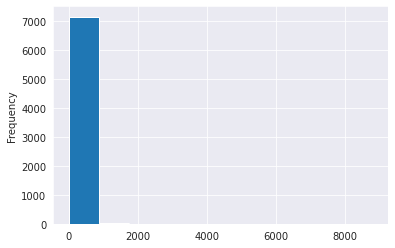

In [32]:
cleaned_df["price"].plot.hist();

In [33]:
find_outliers(cleaned_df, column="price")

{'low': [],
 'high': [354.0,
  355.0,
  357.0,
  358.0,
  359.0,
  360.0,
  361.0,
  363.0,
  364.0,
  365.0,
  366.0,
  368.0,
  369.0,
  372.0,
  373.0,
  374.0,
  375.0,
  377.0,
  379.0,
  380.0,
  381.0,
  382.0,
  383.0,
  384.0,
  385.0,
  386.0,
  387.0,
  390.0,
  392.0,
  393.0,
  394.0,
  395.0,
  397.0,
  398.0,
  399.0,
  400.0,
  401.0,
  402.0,
  408.0,
  411.0,
  413.0,
  414.0,
  415.0,
  416.0,
  420.0,
  421.0,
  422.0,
  425.0,
  426.0,
  427.0,
  428.0,
  429.0,
  430.0,
  431.0,
  434.0,
  435.0,
  440.0,
  443.0,
  444.0,
  445.0,
  448.0,
  449.0,
  450.0,
  451.0,
  455.0,
  459.0,
  460.0,
  465.0,
  466.0,
  470.0,
  471.0,
  472.0,
  475.0,
  476.0,
  478.0,
  479.0,
  480.0,
  485.0,
  486.0,
  487.0,
  488.0,
  490.0,
  495.0,
  499.0,
  500.0,
  513.0,
  514.0,
  516.0,
  521.0,
  524.0,
  525.0,
  528.0,
  529.0,
  534.0,
  535.0,
  540.0,
  545.0,
  550.0,
  555.0,
  557.0,
  564.0,
  567.0,
  568.0,
  575.0,
  580.0,
  585.0,
  587.0,
  590.0,
  594.0,

<AxesSubplot:>

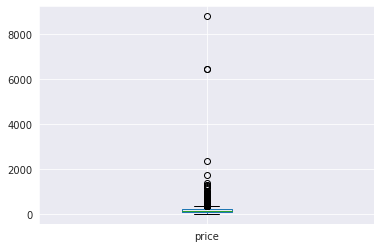

In [34]:
cleaned_df.boxplot(column=["price"])

### Now Look Again at the Data

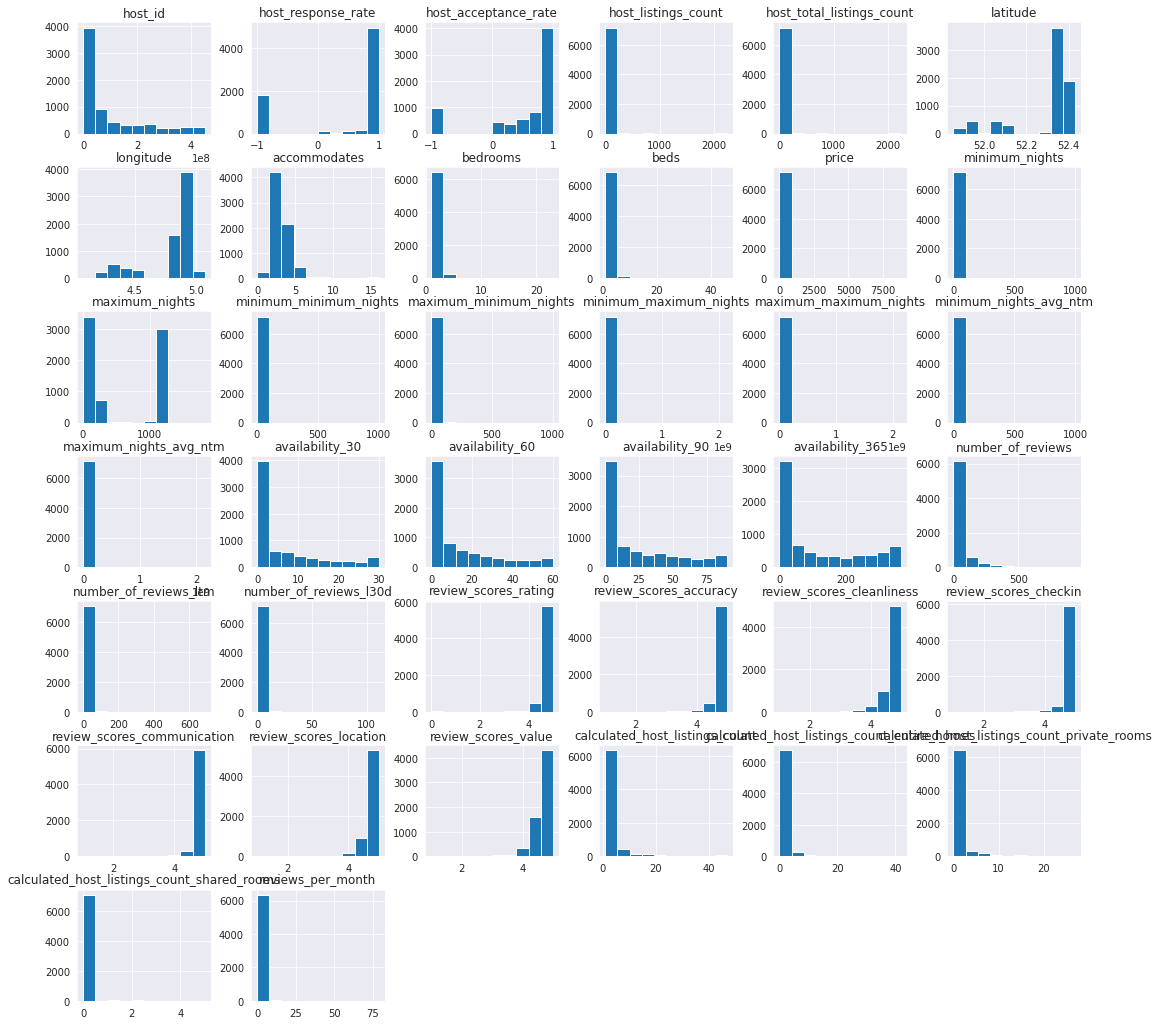

In [35]:
cleaned_df.hist(figsize=(18, 18));

In [36]:
df.isna().sum()

listing_url                                       0
scrape_id                                         0
last_scraped                                      0
name                                              0
description                                      24
                                               ... 
calculated_host_listings_count_entire_homes       0
calculated_host_listings_count_private_rooms      0
calculated_host_listings_count_shared_rooms       0
reviews_per_month                               793
city                                              0
Length: 74, dtype: int64

# Section 4: Data Modeling

**NOTE**: Some transformation were performed only here (not in cleaning section) because those
were not independent between rows. Therefore, we had to compute some values on the train split
and apply them on test split.

In [37]:
model_df = cleaned_df.copy()

## Drop Outliers

In [38]:
# Drop the price outliers. Those values are taken from the analysis done in the wrangling notebook.
# Probably we could look into more detail into more features, but we wanted to keep things simple, so we looked only at the target/label.
model_df = model_df[(0 < model_df["price"]) & (model_df["price"] < 2000)]

## Check the Target for NaNs

In [39]:
# It doesn't have any NaNs. That is good.
model_df["price"].isna().sum()

0

## Pick Target & Split Data

In [40]:
# Pick the features matrix and the ground truth.
X = model_df.drop(columns=["price"])
y = model_df["price"]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=True)

In [42]:
print(f"The train split has {len(X_train)} items.")

The train split has 5719 items.


In [43]:
print(f"The test split has {len(X_test)} items.")

The test split has 1430 items.


## Transform DateTime Features

In [44]:
def compute_time_delta(df: pd.DataFrame, columns: List[str], min_max_scaler: Optional[MinMaxScaler] = None) -> Tuple[pd.DataFrame, MinMaxScaler]:
    """
    Transforms all the given columns, that contain datetime data, into deltas relative to the minimum datetime within each column.
    The function will also map the data into a [0, 1] interval.

        :param df: The DataFrame the function will be looking in.
        :param columns: A list of columns that contain datetime information.
        :param min_max_scaler: The sklearn MinMaxScaler that will be used. If "None" a new scaler will be created and fitted on the data.
        :return: The transformed DataFrame.
    """

    for column in columns:
        df[column] = pd.to_datetime(df[column], format="%Y-%m-%d")
    df[columns] = df[columns].apply(lambda row: [item.value for item in row], axis=1, result_type='expand')

    if min_max_scaler is None:
        min_max_scaler = MinMaxScaler()
        df[columns] = min_max_scaler.fit_transform(df[columns])
    else:
        df[columns] = min_max_scaler.transform(df[columns])

    return df, min_max_scaler

In [45]:
X_train, min_max_scaler = compute_time_delta(X_train, columns=["host_since", "first_review", "last_review"])
X_test, _ = compute_time_delta(X_test, columns=["host_since", "first_review", "last_review"], min_max_scaler=min_max_scaler)

In [46]:
X_train.head()

,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,...,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,has_license,is_bathroom_private
id,,,,,,,,,,,,,,,,,,,,,
51276445,53335715,0.539695,a few days or more,0.0,0.40,f,NaN,0,0,"['email', 'phone', 'jumio', 'offline_governmen...",...,5.00,f,1,1,0,0,0.25,Amsterdam,t,f
25330294,9282300,0.373401,a few days or more,0.2,0.86,f,Grachtengordel,9,9,"['email', 'phone', 'jumio', 'offline_governmen...",...,NaN,f,9,9,0,0,NaN,Amsterdam,t,f
3280939,16582432,0.423147,within a day,1.0,0.71,f,Museumkwartier,1,1,"['email', 'phone', 'reviews', 'jumio']",...,4.61,f,1,1,0,0,0.44,Amsterdam,t,f
378523,1901477,0.256650,within an hour,1.0,0.90,t,Nieuwmarkt en Lastage,1,1,"['email', 'phone', 'reviews', 'jumio']",...,4.81,t,1,1,0,0,0.95,Amsterdam,t,f
29181440,31540174,0.486904,within an hour,1.0,1.00,f,De Pijp,2,2,"['email', 'phone', 'reviews', 'jumio']",...,4.40,t,1,1,0,0,0.12,Amsterdam,t,f


In [47]:
X_test.head()

,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,...,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,has_license,is_bathroom_private
id,,,,,,,,,,,,,,,,,,,,,
46635056,7012495,0.351269,within a few hours,1.00,0.71,f,NaN,0,0,"['email', 'phone', 'reviews', 'jumio']",...,5.00,f,1,1,0,0,0.31,Amsterdam,t,f
35176175,19965139,0.436345,within a day,1.00,0.80,f,NaN,1,1,"['email', 'phone', 'facebook', 'reviews', 'jum...",...,4.20,f,1,1,0,0,0.15,Amsterdam,t,f
53122889,72558816,0.566904,within a day,0.90,0.43,f,NaN,2,2,"['email', 'phone', 'facebook', 'reviews', 'jum...",...,5.00,f,1,1,0,0,0.53,Amsterdam,t,f
21931660,56997633,0.545381,within an hour,1.00,1.00,f,Spaarndammer en Zeeheldenbuurt,3,3,"['phone', 'reviews', 'jumio', 'offline_governm...",...,4.46,t,3,0,3,0,1.39,Amsterdam,t,t
30265278,85420364,0.580508,within an hour,0.97,1.00,t,De Wallen,4,4,"['email', 'phone', 'reviews', 'jumio', 'offlin...",...,4.59,t,2,0,2,0,2.90,Amsterdam,t,t


## List to Columns

In [48]:
def str_list_to_list(item: str) -> List[str]:
    """
        Transforms a string object to a Python one.
    """

    return eval(item)

def list_to_columns(df: pd.DataFrame, column: str, most_common_n: int = 5, most_frequent_columns: Optional[List[str]] = None) -> Tuple[pd.DataFrame, List[str]]:
    """
    Function that takes columns that contain lists, computes the most common ocurrancies and puts the "most_common_n" items as boolean columns.

        :param df: The DataFrame that will be transformed.
        :param column: The column that contains data as lists.
        :param most_common_n: The number of most common items that will be pivoted as columns.
        :param most_frequent_columns: If "most_frequent_columns != None" than the most common items wont be computed on the given dataset and this
         list will be used as references.

        :return: A copy of the transformed DataFrame.
    """
    df = df.copy()

    rows = df[column].transform(lambda item: str_list_to_list(item))

    if most_frequent_columns is None:
        counter = Counter()
        for row in rows:
            for item in row:
                counter[item] += 1
        columns = [c[0] for c in counter.most_common(most_common_n)]
    else:
        columns = most_frequent_columns[:most_common_n]
    rows = [
        ["t" if col in row else "f" for col in columns]
        for row in rows
    ]
    column_names = [f"{column}_{c}" for c in columns]
    df[column_names] = rows

    df = df.drop(columns=[column])

    return df, columns

In [49]:
X_train, columns_host_verifications = list_to_columns(X_train, column="host_verifications")
X_test, _ = list_to_columns(X_test, column="host_verifications", most_frequent_columns=columns_host_verifications)

In [50]:
X_train, columns_amenities = list_to_columns(X_train, column="amenities", most_common_n=10)
X_test, _ = list_to_columns(X_test, column="amenities", most_frequent_columns=columns_amenities, most_common_n=10)

In [51]:
X_train.head()

,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,...,amenities_Wifi,amenities_Essentials,amenities_Smoke alarm,amenities_Heating,amenities_Hangers,amenities_Hair dryer,amenities_Hot water,amenities_Kitchen,amenities_Long term stays allowed,amenities_Iron
id,,,,,,,,,,,,,,,,,,,,,
51276445,53335715,0.539695,a few days or more,0.0,0.40,f,NaN,0,0,t,...,t,f,f,f,f,f,f,t,t,f
25330294,9282300,0.373401,a few days or more,0.2,0.86,f,Grachtengordel,9,9,t,...,t,t,t,t,t,t,f,t,t,t
3280939,16582432,0.423147,within a day,1.0,0.71,f,Museumkwartier,1,1,t,...,t,t,t,t,t,t,t,t,t,t
378523,1901477,0.256650,within an hour,1.0,0.90,t,Nieuwmarkt en Lastage,1,1,t,...,t,t,t,t,t,t,t,t,f,t
29181440,31540174,0.486904,within an hour,1.0,1.00,f,De Pijp,2,2,t,...,t,t,t,t,t,t,t,t,f,t


In [52]:
X_test.head()

,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,...,amenities_Wifi,amenities_Essentials,amenities_Smoke alarm,amenities_Heating,amenities_Hangers,amenities_Hair dryer,amenities_Hot water,amenities_Kitchen,amenities_Long term stays allowed,amenities_Iron
id,,,,,,,,,,,,,,,,,,,,,
46635056,7012495,0.351269,within a few hours,1.00,0.71,f,NaN,0,0,t,...,t,t,f,t,t,f,t,t,f,t
35176175,19965139,0.436345,within a day,1.00,0.80,f,NaN,1,1,t,...,t,t,t,t,t,t,t,t,f,t
53122889,72558816,0.566904,within a day,0.90,0.43,f,NaN,2,2,t,...,t,t,f,f,t,f,t,t,t,t
21931660,56997633,0.545381,within an hour,1.00,1.00,f,Spaarndammer en Zeeheldenbuurt,3,3,t,...,t,t,t,t,t,t,t,t,t,t
30265278,85420364,0.580508,within an hour,0.97,1.00,t,De Wallen,4,4,t,...,t,t,t,t,t,t,t,f,t,t


## Impute Values

In [53]:
# Look at what columns have missing values.
nans_mask = (X_train.isna() | X_test.isna()).any(axis=0)
nans_mask = nans_mask[nans_mask == True]
nans_mask

host_response_time             True
host_neighbourhood             True
bedrooms                       True
beds                           True
review_scores_rating           True
review_scores_accuracy         True
review_scores_cleanliness      True
review_scores_checkin          True
review_scores_communication    True
review_scores_location         True
review_scores_value            True
reviews_per_month              True
dtype: bool

### Categorical
Impute categorical variables using "mode".

In [54]:
OBJECT_CATEGORICAL_VARIABLES = X_train.select_dtypes(include=["object"]).columns

In [55]:
object_categorical_mode_imputer = SimpleImputer(strategy="most_frequent")
X_train[OBJECT_CATEGORICAL_VARIABLES] = object_categorical_mode_imputer.fit_transform(X_train[OBJECT_CATEGORICAL_VARIABLES])

In [56]:
X_test[OBJECT_CATEGORICAL_VARIABLES] = object_categorical_mode_imputer.transform(X_test[OBJECT_CATEGORICAL_VARIABLES])

In [57]:
X_train.head()

,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,...,amenities_Wifi,amenities_Essentials,amenities_Smoke alarm,amenities_Heating,amenities_Hangers,amenities_Hair dryer,amenities_Hot water,amenities_Kitchen,amenities_Long term stays allowed,amenities_Iron
id,,,,,,,,,,,,,,,,,,,,,
51276445,53335715,0.539695,a few days or more,0.0,0.40,f,Oud-West,0,0,t,...,t,f,f,f,f,f,f,t,t,f
25330294,9282300,0.373401,a few days or more,0.2,0.86,f,Grachtengordel,9,9,t,...,t,t,t,t,t,t,f,t,t,t
3280939,16582432,0.423147,within a day,1.0,0.71,f,Museumkwartier,1,1,t,...,t,t,t,t,t,t,t,t,t,t
378523,1901477,0.256650,within an hour,1.0,0.90,t,Nieuwmarkt en Lastage,1,1,t,...,t,t,t,t,t,t,t,t,f,t
29181440,31540174,0.486904,within an hour,1.0,1.00,f,De Pijp,2,2,t,...,t,t,t,t,t,t,t,t,f,t


In [58]:
X_test.head()

,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,...,amenities_Wifi,amenities_Essentials,amenities_Smoke alarm,amenities_Heating,amenities_Hangers,amenities_Hair dryer,amenities_Hot water,amenities_Kitchen,amenities_Long term stays allowed,amenities_Iron
id,,,,,,,,,,,,,,,,,,,,,
46635056,7012495,0.351269,within a few hours,1.00,0.71,f,Oud-West,0,0,t,...,t,t,f,t,t,f,t,t,f,t
35176175,19965139,0.436345,within a day,1.00,0.80,f,Oud-West,1,1,t,...,t,t,t,t,t,t,t,t,f,t
53122889,72558816,0.566904,within a day,0.90,0.43,f,Oud-West,2,2,t,...,t,t,f,f,t,f,t,t,t,t
21931660,56997633,0.545381,within an hour,1.00,1.00,f,Spaarndammer en Zeeheldenbuurt,3,3,t,...,t,t,t,t,t,t,t,t,t,t
30265278,85420364,0.580508,within an hour,0.97,1.00,t,De Wallen,4,4,t,...,t,t,t,t,t,t,t,f,t,t


#### Continuous
Impute continuous variables using "mean".

In [59]:
X.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [60]:
nans_mask = (X_train.isna() | X_test.isna()).any(axis=0)
nans_mask = nans_mask[nans_mask == True]
nans_mask

bedrooms                       True
beds                           True
review_scores_rating           True
review_scores_accuracy         True
review_scores_cleanliness      True
review_scores_checkin          True
review_scores_communication    True
review_scores_location         True
review_scores_value            True
reviews_per_month              True
dtype: bool

In [61]:
continuous_nan_columns = set(nans_mask.index) - set(OBJECT_CATEGORICAL_VARIABLES)
continuous_nan_columns = list(continuous_nan_columns)
continuous_nan_columns

['beds',
 'review_scores_accuracy',
 'review_scores_communication',
 'bedrooms',
 'review_scores_value',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_rating',
 'reviews_per_month',
 'review_scores_location']

In [62]:
mean_imputer = SimpleImputer(strategy="mean")
X_train[continuous_nan_columns] = mean_imputer.fit_transform(X_train[continuous_nan_columns])

In [63]:
nans_mask = (X_train.isna() | X_test.isna()).any(axis=0)
nans_mask = nans_mask[nans_mask == True]
nans_mask

Series([], dtype: bool)

## Categorical Variables
The models that we indent to use can handle categorical variables as long as we map them to
ordinal variables. Therefore, there is no need for OHE (or other methods).

In [64]:
from sklearn.base import TransformerMixin


class FeatureTransformer(TransformerMixin):
    """
        Class that transform object categorical variables to ordinal ones.
        The "transform" method handles unseen data by taking the last ordinal values used and adding one.
    """

    def __init__(self, categorical_features: List[str]):
        self.categorical_features = categorical_features

    def fit(self, X):

        if not isinstance(X, pd.DataFrame):
            raise ValueError("Pass a pandas.DataFrame")

        if not isinstance(self.categorical_features, list):
            raise ValueError(
                "Pass categorical_features as a list of column names")

        self.encoding = {}
        for c in self.categorical_features:

            _, int_id = X[c].factorize()
            self.encoding[c] = dict(zip(list(int_id), range(0,len(int_id)+1)))

        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Pass a pandas.DataFrame")

        if not hasattr(self, 'encoding'):
            raise AttributeError("FeatureTransformer must be fitted")

        df = X.drop(self.categorical_features, axis=1)

        for c in sorted(self.categorical_features):
            df[c] = X[c].map(self.encoding[c]).fillna(0).astype("int")

        return df

In [65]:
encoder = FeatureTransformer(categorical_features=list(OBJECT_CATEGORICAL_VARIABLES))
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [66]:
X_train.head()

,host_id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,...,host_verifications_email,host_verifications_government_id,host_verifications_jumio,host_verifications_phone,host_verifications_reviews,instant_bookable,is_bathroom_private,neighbourhood_cleansed,property_type,room_type
id,,,,,,,,,,,,,,,,,,,,,
51276445,53335715,0.539695,0.0,0.40,0,0,52.36261,4.85446,2,1.0,...,0,0,0,0,0,0,0,0,0,0
25330294,9282300,0.373401,0.2,0.86,9,9,52.36430,4.88867,2,1.0,...,0,0,0,0,0,0,0,1,1,0
3280939,16582432,0.423147,1.0,0.71,1,1,52.35396,4.87842,5,3.0,...,0,1,0,0,1,0,0,2,2,0
378523,1901477,0.256650,1.0,0.90,1,1,52.37420,4.90401,2,1.0,...,0,1,0,0,1,1,0,1,3,0
29181440,31540174,0.486904,1.0,1.00,2,2,52.35646,4.88986,4,3.0,...,0,1,0,0,1,1,0,3,1,0


In [67]:
X_test.head()

,host_id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,...,host_verifications_email,host_verifications_government_id,host_verifications_jumio,host_verifications_phone,host_verifications_reviews,instant_bookable,is_bathroom_private,neighbourhood_cleansed,property_type,room_type
id,,,,,,,,,,,,,,,,,,,,,
46635056,7012495,0.351269,1.00,0.71,0,0,52.36084,4.89542,4,3.0,...,0,1,0,0,1,0,0,1,1,0
35176175,19965139,0.436345,1.00,0.80,1,1,52.35984,4.85391,4,1.0,...,0,1,0,0,1,0,0,0,1,0
53122889,72558816,0.566904,0.90,0.43,2,2,52.36840,4.86567,2,1.0,...,0,0,0,0,1,0,0,0,21,0
21931660,56997633,0.545381,1.00,1.00,3,3,52.38951,4.87912,2,1.0,...,1,0,0,0,1,1,1,34,8,1
30265278,85420364,0.580508,0.97,1.00,4,4,52.37106,4.89581,2,1.0,...,0,0,0,0,1,1,1,5,8,1


In [68]:
X_train.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [69]:
X_test.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

## Train the Model

In [70]:
params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}

lgb_train = lgb.Dataset(X_train, y_train)

evals_result = {}
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train],
    categorical_feature=list(OBJECT_CATEGORICAL_VARIABLES),
    verbose_eval=5,
    evals_result=evals_result,
    early_stopping_rounds=20
)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
categorical_feature in Dataset is overridden.
New categorical_feature is ['amenities_Essentials', 'amenities_Hair dryer', 'amenities_Hangers', 'amenities_Heating', 'amenities_Hot water', 'amenities_Iron', 'amenities_Kitchen', 'amenities_Long term stays allowed', 'amenities_Smoke alarm', 'amenities_Wifi', 'city', 'has_availability', 'has_license', 'host_has_profile_pic', 'host_identity_verified', 'host_is_superhost', 'host_neighbourhood', 'host_response_time', 'host_verifications_email', 'host_verifications_government_id', 'host_verifications_jumio', 'host_verifications_phone', 'host_verifications_reviews', 'instant_bookable', 'is_bathroom_private', 'neighbourhood_cleansed', 'property_type', 'room_type']
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callb

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4353
[LightGBM] [Info] Number of data points in the train set: 5719, number of used features: 65
[LightGBM] [Info] Start training from score 162.716034
Training until validation scores don't improve for 20 rounds
[5]	training's rmse: 109.304
[10]	training's rmse: 107.968
[15]	training's rmse: 106.704
[20]	training's rmse: 105.393
[25]	training's rmse: 104.174
[30]	training's rmse: 102.917
[35]	training's rmse: 101.738
[40]	training's rmse: 100.556
[45]	training's rmse: 99.5113
[50]	training's rmse: 98.4276
[55]	training's rmse: 97.3486
[60]	training's rmse: 96.3334
[65]	training's rmse: 95.2961
[70]	training's rmse: 94.2839
[75]	training's rmse: 93.2874
[80]	training's rmse: 92.4066
[85]	training's rmse: 91.5088
[90]

## Test model

In [71]:
y_test_pred = gbm.predict(X_test)

print(f"R2 Score: {r2_score(y_test, y_test_pred):.4f}")
print(f"RMSE Score: {mean_squared_error(y_test, y_test_pred, squared=False):.4f}")

R2 Score: 0.5563
RMSE Score: 73.9259


# Section 5: Evaluation

### Color Palette

In [72]:
# Define global color palette that would be used through all the graphs.
COLOR_PALETTE = sns.color_palette("crest")
COLOR_PALETTE

[(0.48942421, 0.72854938, 0.56751036),
 (0.34892097, 0.64828676, 0.56513633),
 (0.24929311, 0.56486397, 0.5586654),
 (0.15615526, 0.47913212, 0.54850526),
 (0.11131735, 0.39155635, 0.53422678),
 (0.14573579, 0.29354139, 0.49847009)]

In [73]:
sns.set_palette(COLOR_PALETTE)

## Question 1: Which city has the highest price tag? What about their neighborhoods?

### By City

In [74]:
# Compute the mean price over all the cities.
city_prices = cleaned_df.groupby("city")["price"].mean()
city_prices = city_prices.sort_values(ascending=True)
city_prices = city_prices.reset_index()

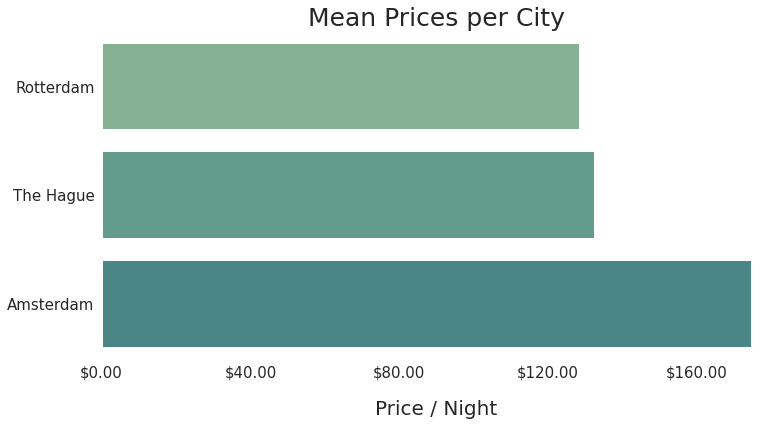

In [75]:
# Plot the mean prices as a bar plot.
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax = sns.barplot(x="price", y="city", data=city_prices, orient="h", ax=ax)

ax.set_xlabel("Price / Night", fontsize=20)
ax.set_ylabel("", fontsize=20)

ax.set_xlim(0, 180)

ax.xaxis.set_major_locator(MultipleLocator(40))
ax.xaxis.set_major_formatter(FormatStrFormatter('$%1.2f'))

ax.set_facecolor("white")
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.labelpad = 20

plt.title("Mean Prices per City", fontsize=25)
plt.savefig(Path("images") / "city_prices.png", bbox_inches="tight")

#### By Neighbourhood

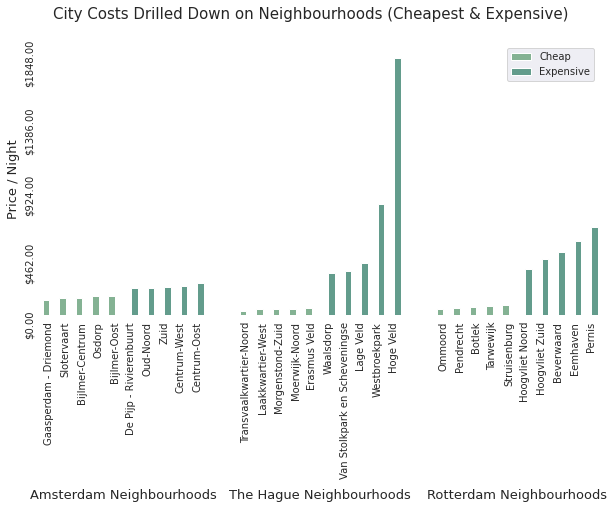

In [76]:
# Compute the mean prices over all the cities and for the most & least expensive neighbourhoods.
# We will plot the results as bar plots.

fig, axes = plt.subplots(1, 3, sharey="all", figsize=(10, 5))
for top_ax, city in zip(axes.flatten(), cleaned_df["city"].unique()):
    city_neighbourhoods = cleaned_df[cleaned_df["city"] == city]
    city_prices = city_neighbourhoods.groupby(["neighbourhood_cleansed"], as_index=False)["price"].mean().sort_values(
        by="price", ascending=True)

    cheap_city_prices = city_prices.iloc[:5].copy()
    cheap_city_prices["cost"] = "Cheap"
    expensive_city_prices = city_prices.iloc[-5:].copy()
    expensive_city_prices["cost"] = "Expensive"
    aggregated_city_prices = pd.concat([cheap_city_prices, expensive_city_prices], axis=0)

    aggregated_city_prices["neighbourhood_cleansed"] = aggregated_city_prices["neighbourhood_cleansed"].transform(
        lambda item: " ".join(item.split(" ")[:4]))
    ax = sns.barplot(x="neighbourhood_cleansed", y="price", data=aggregated_city_prices, hue="cost", ax=top_ax)
    if city == "Amsterdam":
        ax.set_ylabel("Price / Night", fontsize=13)
    else:
        ax.set_ylabel("")
    ax.set_xlabel(f"{city} Neighbourhoods", fontsize=13)

    ax.tick_params(labelrotation=90)
    ax.set_facecolor("white")
    ax.get_legend().remove()

    ax.set_ylim(0, 1850)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.xaxis.labelpad = 10

    ax.yaxis.set_major_locator(MultipleLocator(1850 // 4))
    ax.yaxis.set_major_formatter(FormatStrFormatter('$%1.2f'))

plt.legend()
fig.align_xlabels(axes)
fig.suptitle("City Costs Drilled Down on Neighbourhoods (Cheapest & Expensive)", fontsize=15)
plt.savefig(Path("images") / "city_neighbourhood_prices.png", bbox_inches="tight")

Bar charts that show the mean price/night in different cities
and neighborhoods.

## Question 2: What city and neighborhoods are in most demand?

In [77]:
# Possible availability columns.
[c for c in df.columns if "availability" in c]

['has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365']

In [78]:
# Possible occupancy columns.
[c for c in df.columns if "occupancy" in c]

[]

In [79]:
print(f"Availability percentage: {(len(df) - len(df[df['has_availability'] == 'f'])) / len(df)}")
print("We can see that most of the properties do have availability information.")

Availability percentage: 0.9973478503629257
We can see that most of the properties do have availability information.


In [80]:
def compute_availability_df(df: pd.DataFrame, days: int, group_by: str) -> pd.DataFrame:
    """
        Compute the availability & occupancy mean relative to a given features.

    :param df: The DataFrame we will be doing analytics on.
    :param days: The numbers of availability days (choose from 30, 60, 90, 365).
    :param group_by: The features we will be doing the mean to.

    :return: A DataFrame with mean values relative to "group_by".
    """

    assert days in (30, 60, 90, 365)

    availability_df = df[df["has_availability"] == "t"].copy()

    availability_df = availability_df.groupby(group_by)[[f"availability_{days}", "price"]].\
            mean().\
            sort_values(by=f"availability_{days}", ascending=False).\
            reset_index()
    availability_df[f"occupancy_{days}"] = days - availability_df[f"availability_{days}"]

    return availability_df

#### By City

In [81]:
def render_city_occupancy_plot(df: pd.DataFrame, days: int):
    """
        Render the occupancy information as bar plots relative to every city.

        :param df: The DataFrame we will be doing analytics on.
        :param days: The number of availability days (choose from 30, 60, 90, 365).
    """
    availability_df = compute_availability_df(df, days, group_by="city")

    cities = availability_df["city"].unique().tolist()
    cities.sort()

    _, ax = plt.subplots(1, 1, sharey="all", figsize=(18, 9))

    ax = sns.barplot(y="city", x=f"occupancy_{days}", data=availability_df, ax=ax, hue_order=cities, orient="h")
    ax.set_xlabel(f"Demand", fontsize=20)
    ax.set_ylabel("")

    ax.tick_params(labelrotation=25)

    x_max = int(availability_df[f"occupancy_{days}"].max() * 1.2)
    ax.set_xlim(0, x_max)

    ax.set_facecolor("white")
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.xaxis.labelpad = 10

    ax.xaxis.set_major_locator(MultipleLocator(x_max // 5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%1.d'))

    plt.title("Demand per City Over the Last 365 Days", fontsize=25)
    plt.savefig(Path("images") / "city_demand.png", bbox_inches="tight")

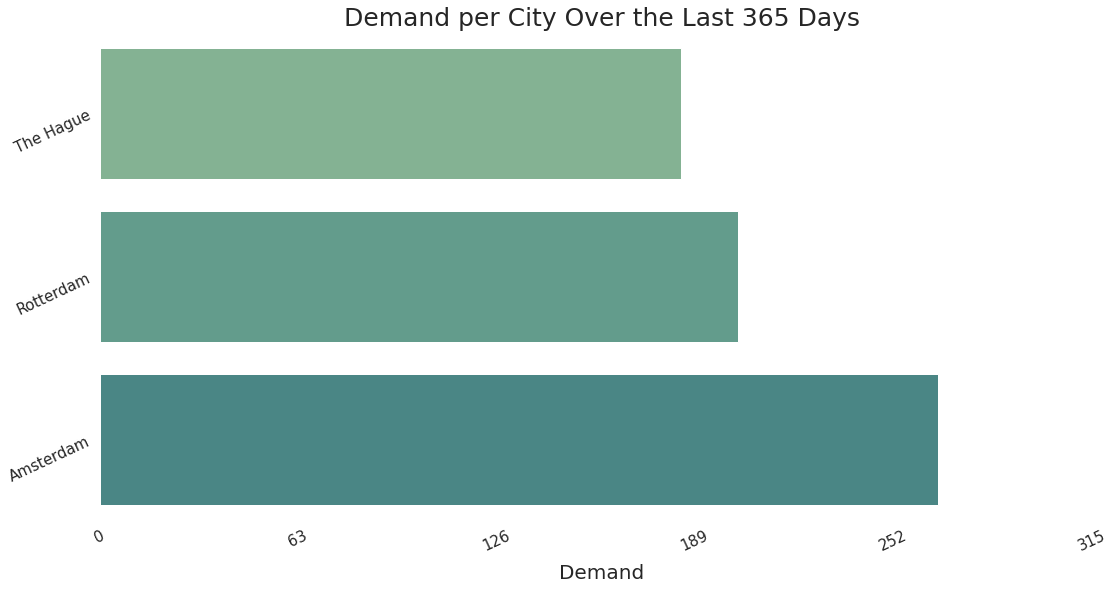

In [82]:
render_city_occupancy_plot(cleaned_df, days=365)

#### By Neighbourhood

In [83]:
def render_neighbourhood_occupancy_plot(df: pd.DataFrame, days: int, y: str):
    """
        Render the occupancy information as bar plots relative to every city and the most & least occupied neighbourhoods.

        :param df: The DataFrame we will be doing analytics on.
        :param days: The number of availability days (choose from 30, 60, 90, 365).
        :param y: The feature that we want to display on the "y" axis.

    """

    fig, axes = plt.subplots(1, 3, sharey="all", figsize=(10, 5))
    for top_ax, city in zip(axes.flatten(), df["city"].unique()):
        city_neighbourhoods = df[df["city"] == city]
        city_availability_df = compute_availability_df(city_neighbourhoods, days, group_by="neighbourhood_cleansed")
        city_availability_df = city_availability_df.sort_values(by=f"occupancy_{days}", ascending=True)

        low_occupancy_cities = city_availability_df.iloc[:5].copy()
        low_occupancy_cities["occupancy"] = "Least"
        high_occupancy_cities = city_availability_df.iloc[-5:].copy()
        high_occupancy_cities["occupancy"] = "Most"
        aggregated_occupancies = pd.concat([low_occupancy_cities, high_occupancy_cities], axis=0)

        aggregated_occupancies["neighbourhood_cleansed"] = aggregated_occupancies["neighbourhood_cleansed"].transform(
            lambda item: " ".join(item.split(" ")[:4]))
        ax = sns.barplot(x="neighbourhood_cleansed", y=y, data=aggregated_occupancies, hue="occupancy", ax=top_ax)

        # Set label based on specific "city" and "y" property.
        if city == "Amsterdam":
            if "OCCUPANCY" in y.upper():
                ax.set_ylabel("Occupancy", fontsize=13)
            else:
                ax.set_ylabel("Price / Night", fontsize=13)
        else:
            ax.set_ylabel("")
        ax.set_xlabel(f"{city} Neighbourhoods", fontsize=13)

        ax.tick_params(labelrotation=90)
        ax.set_facecolor("white")
        ax.get_legend().remove()

        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.xaxis.labelpad = 10

        if "OCCUPANCY" in y.upper():
            ax.yaxis.set_major_locator(MultipleLocator(50))
            ax.yaxis.set_major_formatter(FormatStrFormatter('%1.d'))
            ax.set_ylim(0, 400)
        else:
            ax.yaxis.set_major_locator(MultipleLocator(150))
            ax.yaxis.set_major_formatter(FormatStrFormatter('$%1.d'))
            ax.set_ylim(0, 700)

    plt.legend()
    fig.align_xlabels(axes)
    fig.suptitle("City Occupancy Drilled Down on Neighbourhoods (Most & Least in Demand)", fontsize=15)
    plt.savefig(Path("images") / f"city_neighbourhood_occupancy_{y}.png", bbox_inches="tight")

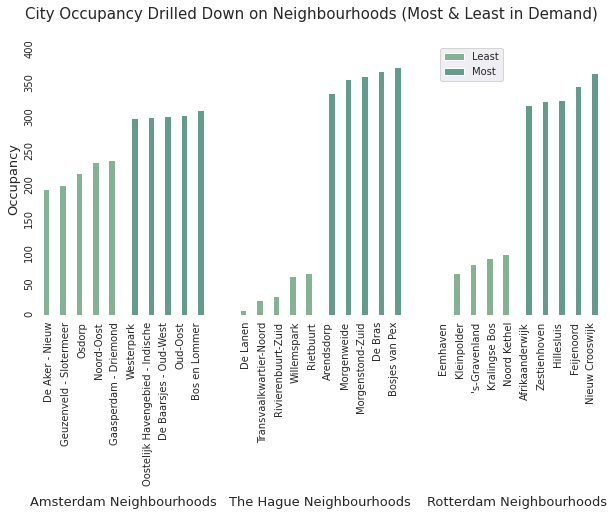

In [84]:
render_neighbourhood_occupancy_plot(cleaned_df, 365, y="occupancy_365")

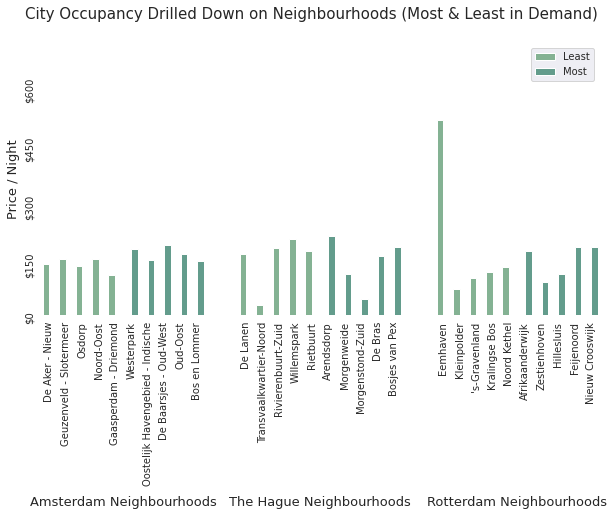

In [85]:
render_neighbourhood_occupancy_plot(cleaned_df, 365, y="price")

Bar charts that show the demand in different cities and neighborhoods.

## Question 3: Are reviews for more expensive houses better?

In [86]:
# Drop the price outliers. Those values are taken from the analysis done in the wrangling notebook.
# Probably we could look into more detail into more features, but we wanted to keep things simple, so we looked only at the target/label.
prices_df = cleaned_df[(0 < cleaned_df["price"]) & (cleaned_df["price"] < 2000)].copy()

In [87]:
# Create a set of bins relative to we will compute the review score rating
price_bins = pd.cut(
    prices_df["price"],
    bins=[0, 250, 500, 750, 1000, 1250, 1500, 1750],
)
prices_df["price_bins"] = price_bins
prices_df["price_bins"]

id
2818                  (0, 250]
20168                 (0, 250]
27886                 (0, 250]
28871                 (0, 250]
29051                 (0, 250]
                        ...   
583946925112383381    (0, 250]
584184287780116672    (0, 250]
584375479743910277    (0, 250]
586855632975181618    (0, 250]
588089624475242042    (0, 250]
Name: price_bins, Length: 7149, dtype: category
Categories (7, interval[int64, right]): [(0, 250] < (250, 500] < (500, 750] < (750, 1000] < (1000, 1250] < (1250, 1500] < (1500, 1750]]

In [88]:
# Compute the mean review score rating for every bin.
price_bin_groups = prices_df.groupby("price_bins")["review_scores_rating"].mean()
price_bin_groups = price_bin_groups.reset_index()
price_bin_groups = price_bin_groups.sort_values(by="price_bins", ascending=True)

# Format the price bins.
price_bin_groups["price_bins_formatted"] = price_bin_groups["price_bins"].transform(
    lambda price_bin: f"${price_bin.left} - ${price_bin.right}", axis=0)
price_bin_groups["price_bins_formatted"]

0        $0 - $250
1      $250 - $500
2      $500 - $750
3     $750 - $1000
4    $1000 - $1250
5    $1250 - $1500
6    $1500 - $1750
Name: price_bins_formatted, dtype: category
Categories (7, object): ['$0 - $250' < '$250 - $500' < '$500 - $750' < '$750 - $1000' < '$1000 - $1250' < '$1250 - $1500' < '$1500 - $1750']

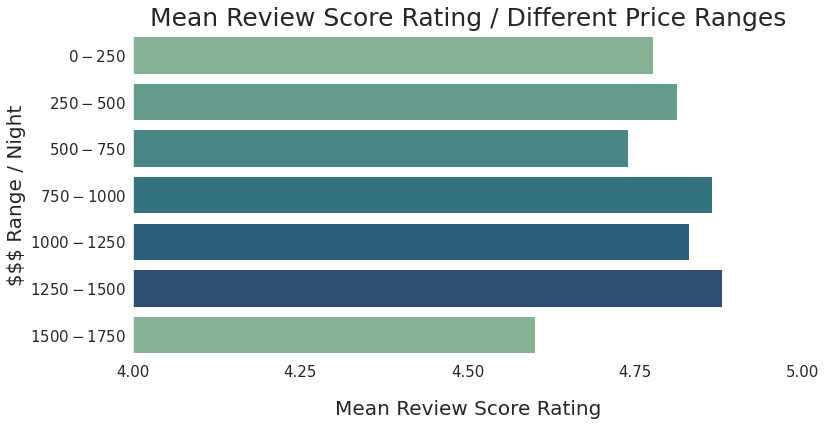

In [89]:
# Plot the mean review score rating as a bar plot.

_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax = sns.barplot(x="review_scores_rating", y="price_bins_formatted", data=price_bin_groups, orient="h", ax=ax,
                 palette=COLOR_PALETTE)

ax.set_xlabel("Mean Review Score Rating", fontsize=20)
ax.set_ylabel("$$$ Range / Night", fontsize=20)

ax.set_xlim(4, 5)

ax.xaxis.set_major_locator(MultipleLocator(0.25))
ax.xaxis.set_major_formatter(FormatStrFormatter('%1.2f'))

ax.set_facecolor("white")
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.labelpad = 20

plt.title("Mean Review Score Rating / Different Price Ranges", fontsize=25)
plt.savefig(Path("images") / "price_bins_review_score_rating.png", bbox_inches="tight")

Bar chart that shows the mean review score rating for different price ranges.

## Question 4: What are the factors that affect a property's price?

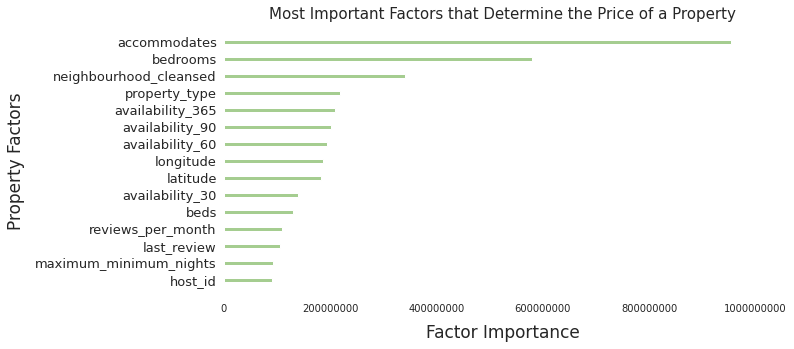

In [90]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", sns.color_palette("crest", as_cmap=True).colors)

ax = lgb.plot_importance(
    gbm,
    max_num_features=15,
    importance_type='gain',
    figsize=(10,5),

)
ax.set_facecolor("white")

ax.set_xlabel("Factor Importance", fontsize=17)
ax.set_ylabel("Property Factors", fontsize=17)
ax.tick_params(axis='y', which='major', labelsize=13)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10

for txt in ax.texts:
    txt.set_visible(False)

ax.xaxis.set_major_formatter(FormatStrFormatter('%1.d'))

plt.title("Most Important Factors that Determine the Price of a Property", fontsize=15)
plt.savefig(Path("images") / "lightgbm.png", bbox_inches = "tight")

Bar charts that show the feature importance of the LightGBM model.

#### SHAPELY Feature Importance (Optional)

In [91]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)

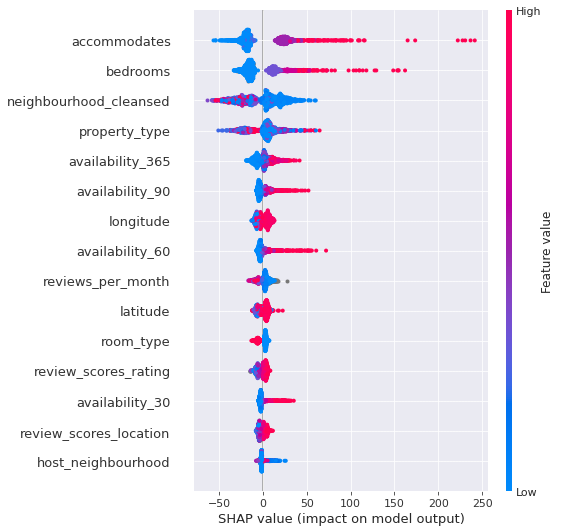

In [92]:
shap.summary_plot(
    shap_values,
    X_test,
    max_display=15,
    title="Most Important Characteristics that Determine the Price of a Property"
)